# MNIST DATASET

# Intro

The goal of this project is a simple classification of hand-written digits from the infamous MNIST dataset.

# EDA

First of all, I need to import required (for now) libraries.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import random

import tensorflow as tf

I will start with a simple overview of the dataset.

In [21]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('train images array shape', x_train.shape)
print('train labels array shape', y_train.shape)
print('test images array shape', x_test.shape)
print('test labels array shape', y_test.shape)

train images array shape (60000, 28, 28)
train labels array shape (60000,)
test images array shape (10000, 28, 28)
test labels array shape (10000,)


Thus we have 3D tensor representing a list of 28*28-pixel images (or matrices) of handwritten digits.

Now I will determine how many unique classes this dataset has as well as their distribution.

number of unique classes:  0    10
dtype: int64


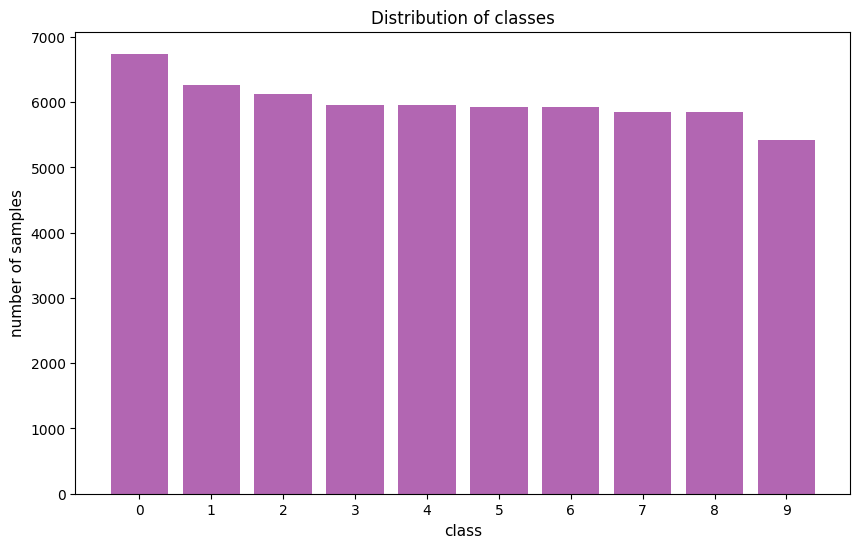

In [22]:
x_train_df = pd.DataFrame(x_train.reshape((60000, 28 * 28)))
y_train_df = pd.DataFrame(y_train)

print('number of unique classes: ', y_train_df.nunique())
class_distr = y_train_df.value_counts()
ticks_distr = np.arange(0, 10, 1)

plt.figure(figsize=(10, 6))
plt.bar(ticks_distr, class_distr, color='purple', alpha=0.6)
plt.xticks(ticks_distr)
plt.title('Distribution of classes', fontsize=12)
plt.ylabel('number of samples', fontsize=11)
plt.xlabel('class', fontsize=11)
plt.show();

There is a small imbalanceness, however, at this point I can't possibly know how it will affect the performance of the models. So in the following there might be a reason to make some additional preprocessing of the data.

Now I will look at the overall characteristics of the data.

In [23]:
display(x_train_df.describe())

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


The data behaves quite well. The values that samples can take are within reasonable range (0-255).

Now I will check if the dataset has duplicates.

In [24]:
print(x_train_df.duplicated().sum())

0


Let's take a closer look at the samples:

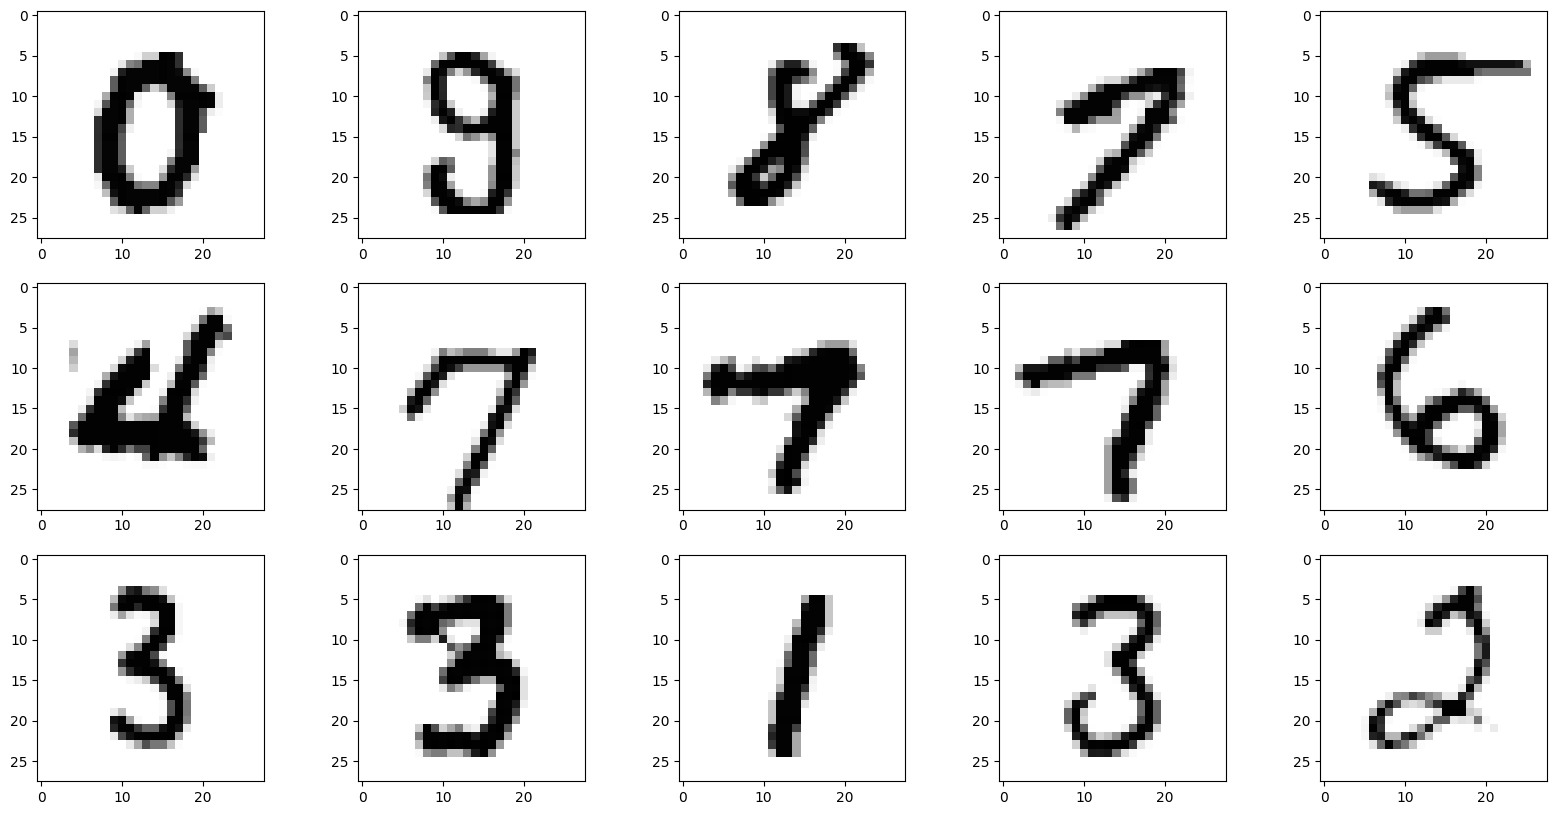

In [25]:
plt.rcParams["figure.figsize"] = (20, 10)
for i in range (1, 16):
    plt.subplot(3, 5, i)
    sample_vector = x_train[random.randint(1, len(x_train)), :]
    plt.imshow(sample_vector, cmap='Greys')

# Modelling

First of all, import all needed libraries.

In [45]:
from keras import models, layers, optimizers
import keras_tuner as kt

In [26]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


Convert images into 1D tensor with values from 0 to 1.

In [27]:
x_train = x_train.reshape((60000, 28 * 28))
x_train = x_train.astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28))
x_test = x_test.astype('float32') / 255

Convert target vector into binary class matrix.

In [29]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Define the function for creating a model with given hyperparameters values (which later will be used in tuning).

In [31]:
def model_builder(hp):
    model = models.Sequential()

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value=300, max_value=500, step=100)
    hp_layer_2 = hp.Int('layer_2', min_value=100, max_value=300, step=50)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0002, 0.0005, 0.0008, 0.001, 0.002, 0.003])

    model.add(layers.Dense(units=hp_layer_1, activation=hp_activation))
    model.add(layers.Dense(units=hp_layer_2, activation=hp_activation))
    model.add(layers.Dense(units=10, activation='softmax'))

    model.compile(optimizer=optimizers.legacy.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

I've decided to use Hyperband tuner to search for model with optimal hyperparameters.

In [32]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=4,
                     directory='dir',
                     project_name='x',
                     overwrite=True)

Define a condition for early stopping to save time and computational resources.

In [33]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

Finally, search for the actual optimal model.  
I've decided to use validation set to evaluate model's performance since it is more objective rather than evaluating it on train data (which model has already seen).

In [34]:
tuner.search(x_train, y_train, validation_split=0.15, epochs=50, batch_size=128, callbacks=[stop_early])

Trial 44 Complete [00h 02m 06s]
val_accuracy: 0.9794444441795349

Best val_accuracy So Far: 0.9835555553436279
Total elapsed time: 00h 20m 45s
INFO:tensorflow:Oracle triggered exit


Extract best found hyperparameters.

In [35]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Then build a model with these parameters and train it on the train data.

In [36]:
tuned_model = tuner.hypermodel.build(best_hps)
history = tuned_model.fit(x_train, y_train, epochs=50, validation_split=0.15, callbacks=[stop_early])

Epoch 1/50


2024-09-03 23:33:43.906318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1594/1594 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9338

2024-09-03 23:34:06.394866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1594/1594 [==============================] - 26s 16ms/step - loss: 0.2222 - accuracy: 0.9338 - val_loss: 0.1141 - val_accuracy: 0.9650
Epoch 2/50
1594/1594 [==============================] - 21s 13ms/step - loss: 0.0854 - accuracy: 0.9740 - val_loss: 0.0960 - val_accuracy: 0.9702
Epoch 3/50
1594/1594 [==============================] - 22s 14ms/step - loss: 0.0533 - accuracy: 0.9831 - val_loss: 0.0841 - val_accuracy: 0.9744
Epoch 4/50
1594/1594 [==============================] - 21s 13ms/step - loss: 0.0373 - accuracy: 0.9882 - val_loss: 0.0905 - val_accuracy: 0.9742
Epoch 5/50
1594/1594 [==============================] - 20s 13ms/step - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.0781 - val_accuracy: 0.9792
Epoch 6/50
1594/1594 [==============================] - 20s 12ms/step - loss: 0.0220 - accuracy: 0.9927 - val_loss: 0.0860 - val_accuracy: 0.9767
Epoch 7/50
1594/1594 [==============================] - 21s 13ms/step - loss: 0.0160 - accuracy: 0.9945 - val_loss: 0.0854 - val_accura

It's also interesting to see how does the number of epochs affect model's performance.

In [37]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

/var/folders/qz/3kcb9rx96w59f3n6xcwd21fw0000gn/T/ipykernel_85432/1376980326.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show();


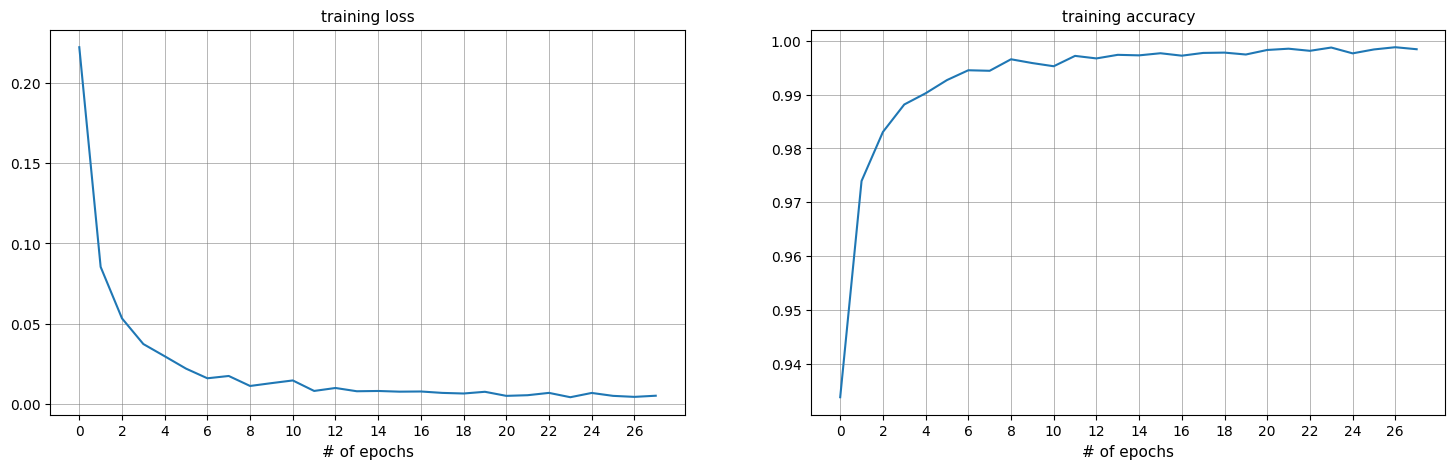

In [38]:
num_epochs = np.arange(len(train_loss))

figure, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 5))
ax1.plot(num_epochs, train_loss)
ax1.set_title('training loss', fontsize=11)
ax1.set_xlabel('# of epochs', fontsize=11)
ax1.set_xticks(num_epochs[::2])
ax1.grid(True)
ax1.grid(color='gray', linestyle='-', linewidth=0.4)
ax2.plot(num_epochs, train_accuracy)
ax2.set_title('training accuracy', fontsize=11)
ax2.set_xlabel('# of epochs', fontsize=11)
ax2.grid(True)
ax2.grid(color='gray', linestyle='-', linewidth=0.4)
figure.show();

We can observe fewer number of epochs on the plots. This is beacause of the stop_early condition.

Let's now evaluate the best model on the given data and compare them to see if we have overfitting:

In [39]:
train_results = tuned_model.evaluate(x_train, y_train, return_dict=True)
test_results = tuned_model.evaluate(x_test, y_test, return_dict=True)

313/313 [==============================] - 3s 9ms/step - loss: 0.1166 - accuracy: 0.9831


In [40]:
print('Results on TRAIN data:')
print('loss:     ', train_results['loss'])
print('accuracy: ', train_results['accuracy'], '\n')
print('Results on TEST data:')
print('loss:     ', test_results['loss'])
print('accuracy: ', test_results['accuracy'], '\n')
if (test_results['accuracy'] <= train_results['accuracy']):
    print('Overfitting!')
    print('Difference between train and test accuracy: ', abs(test_results['accuracy']-train_results['accuracy']))

Results on TRAIN data:
loss:      0.024626312777400017
accuracy:  0.9959666728973389 

Results on TEST data:
loss:      0.11655318737030029
accuracy:  0.9830999970436096 

Overfitting!
Difference between train and test accuracy:  0.012866675853729248


Let's get a closer look of missclassified samples

In [46]:
test_predictions = tuned_model.predict(x_test)
predicted_classes = np.argmax(test_predictions, axis=1)

313/313 [==============================] - 1s 1ms/step


In [47]:
misclassified_indices = np.where(predicted_classes != y_test)[0]

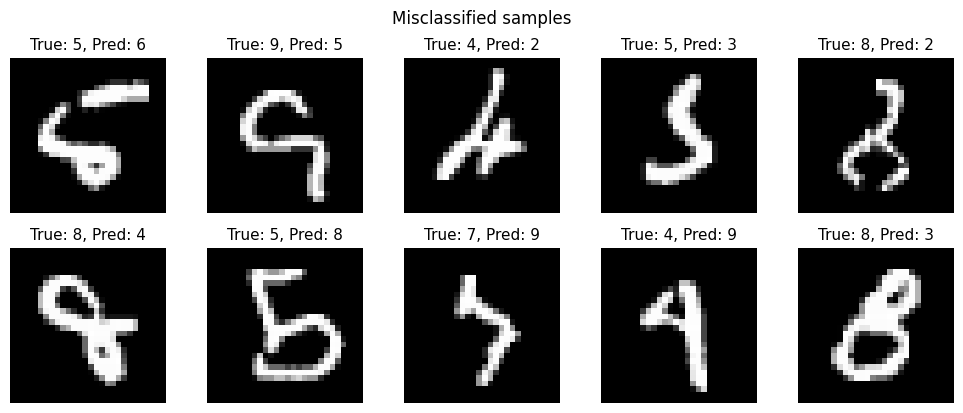

In [48]:
num_display = 10
plt.figure(figsize=(10, 10))

for i, index in enumerate(misclassified_indices[:num_display]):
    plt.subplot(5, 5, i+1)
    image = x_test[index].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {y_test[index]}, Pred: {predicted_classes[index]}", fontsize=11)
    plt.axis('off')

plt.suptitle("Misclassified samples", fontsize=12)
plt.tight_layout()
plt.show()